In [8]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style, get_chunking, get_chunking_dask
import utils

try:
    from yahist import Hist1D, Hist2D
except:
    !pip install git+git://github.com/aminnj/yahist.git#egg=yahist -U
    from yahist import Hist1D, Hist2D

import concurrent.futures

In [9]:
set_plotting_style()

## Make dataframes

In [10]:
executor = concurrent.futures.ProcessPoolExecutor(8)

In [23]:
def make_df(fname,entrystart=None,entrystop=None,bigrho=True):
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(["n*","pass_*",
                     "MET_*",
                     "/BS_(x|y|z)$/",
                     "/Jet_(pt|eta|phi|m)$/",
                     "/Muon_(pt|eta|phi|m|n.*|trackIso|charge|trk_qoverp.*|dxy.*|chi2|ndof|vx|vy|vz|vtxIdx.*|jetIdx.*|good|drjet)$/",
                     "/DV_(tracksSize|chi2|ndof|rho.*|inPixel.*|x|y|z|xError|yError|zError|good)$/",
                     "run","luminosityBlock","event",
                     "L1_DoubleMu4p5_SQ_OS_dR_Max1p2",
                     "L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4",
                     "L1_DoubleMu_15_7",
                    ],outputtype=dict,namedecode="ascii",entrystart=entrystart,entrystop=entrystop)
    
    # booleans for selection
    sel = (
        (arrs["nDV"] == 1) 
        & (arrs["nMuon"] == 2) 
        & arrs["pass_l1"] 
        & arrs["pass_skim"] 
        & arrs["pass_fiducialgen"]
    )
    if bigrho:
        sel = sel & (arrs["DV_rho"]>1.0).any()

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","pass_","BS_","MET_","run","lumi","event","L1_"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]
        if k.startswith("Jet_"):
            # make sure there is at least 1 jet per event, filled with 0s
            padded = arrs[k][sel].pad(1).fillna(0.)
            # convert index of -1 (no jet found) to at least 0, and then we will pick up the 
            # dummy 0s from the padded array
            vals = padded[np.maximum(arrs["Muon_jetIdx1"][sel],0)]
            df[k.replace("Jet_","Muon1_Jet_")] = vals[:,0]
            df[k.replace("Jet_","Muon2_Jet_")] = vals[:,1]

    # augment
    TLVA = uproot_methods.TLorentzVectorArray
    TV2A = uproot_methods.TVector2Array
    TV3A = uproot_methods.TVector3Array
    mu1 = TLVA.from_ptetaphim(df["Muon1_pt"],df["Muon1_eta"],df["Muon1_phi"],0.10566)
    mu2 = TLVA.from_ptetaphim(df["Muon2_pt"],df["Muon2_eta"],df["Muon2_phi"],0.10566)
    jetmu1 = TLVA.from_ptetaphim(df["Muon1_Jet_pt"],df["Muon1_Jet_eta"],df["Muon1_Jet_phi"],df["Muon1_Jet_m"])
    jetmu2 = TLVA.from_ptetaphim(df["Muon2_Jet_pt"],df["Muon2_Jet_eta"],df["Muon2_Jet_phi"],df["Muon2_Jet_m"])
    dimu = mu1+mu2
    df["dimuon_mass"] = dimu.mass
    df["dimuon_eta"] = dimu.eta
    df["dimuon_phi"] = dimu.phi
    df["dimuon_pt"] = dimu.pt
    
    df["dimuon_deltaeta"] = np.abs(mu1.eta - mu2.eta)
    df["dimuon_deltar"] = mu1.delta_r(mu2)
    
    jets = TLVA.from_ptetaphim(arrs["Jet_pt"][sel],arrs["Jet_eta"][sel],arrs["Jet_phi"][sel],arrs["Jet_m"][sel])
    mindrs = dimu.delta_r(jets).min()
    mindrs[~np.isfinite(mindrs)] = 0.
    df["dimuon_drjet"] = mindrs
    
    vecdimu = TV2A.from_polar(dimu.pt,dimu.phi)
    vecdv2d = TV2A.from_cartesian(df["DV_x"]-df["BS_x"],df["DV_y"]-df["BS_y"])
    vecdv3d = TV3A.from_cartesian(df["DV_x"]-df["BS_x"],df["DV_y"]-df["BS_y"],df["DV_z"]-df["BS_z"])
    df["absdphimudv"] = np.abs(vecdimu.delta_phi(vecdv2d))
    df["absdphimumu"] = np.abs(mu1.delta_phi(mu2))
    df["cosphi"] = vecdimu.cosdelta(vecdv2d)
    df["angle3dmumu"] = np.arccos(mu1.p3.dot(mu2.p3)/(mu1.p3.mag*mu2.p3.mag))
    df["angle3dmudv"] = np.arccos(dimu.p3.dot(vecdv3d)/(dimu.p3.mag*vecdv3d.mag))
    df["DV_redchi2"] = df["DV_chi2"]/df["DV_ndof"]
    df["DV_xyErrorMax"] = np.maximum(df["DV_xError"],df["DV_yError"])
    df["Muon1_redchi2"] = df["Muon1_chi2"]/df["Muon1_ndof"]
    df["Muon2_redchi2"] = df["Muon2_chi2"]/df["Muon2_ndof"]
    df["Muon1_adqpt"] = np.abs(df["Muon1_trk_qoverpError"]/df["Muon1_trk_qoverp"])
    df["Muon2_adqpt"] = np.abs(df["Muon2_trk_qoverpError"]/df["Muon2_trk_qoverp"])
    df["Muon1_m"] = 0.10566
    df["Muon2_m"] = 0.10566
    
    df["maxabsdxy"] = np.maximum(np.abs(df["Muon1_dxyCorr"]),np.abs(df["Muon2_dxyCorr"]))
    df["minabsdxy"] = np.minimum(np.abs(df["Muon1_dxyCorr"]),np.abs(df["Muon2_dxyCorr"]))
    df["maxdxy"] = np.maximum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    df["mindxy"] = np.minimum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    
    # skim more
    df = df.query(
        # DV selections
        " (DV_xyErrorMax < 0.05)"
        " and (DV_zError < 0.1)"
        " and (DV_rhoCorr < 11)"
        # angles
        " and (cosphi > 0.)"
        " and (absdphimumu < 2.8)"
        " and (absdphimudv < 0.02)"
        # muon quality
        " and (Muon1_charge != Muon2_charge)"
        " and (Muon1_nValidMuonHits > 0) and (Muon2_nValidMuonHits > 0)"
        " and (Muon1_redchi2 < 3) and (Muon2_redchi2 < 3)"
        # muon isolation
        " and (Muon1_trackIso < 0.1) and (Muon2_trackIso < 0.1)"
        " and ((Muon1_drjet > 0.3) or (Muon1_drjet < 0))"
        " and ((Muon2_drjet > 0.3) or (Muon2_drjet < 0))"
    )
    return df
    
fnames_mc = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v7//output_1.root")
futures_mc = executor.map(make_df, fnames_mc)
fnames_data = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_v7skim1cmjets/*.root")
futures_data = executor.map(make_df, fnames_data)
df_data = pd.concat(tqdm(futures_data,total=len(fnames_data))).reset_index(drop=True)
df_mc = pd.concat(tqdm(futures_mc,total=len(fnames_mc))).reset_index(drop=True)

BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [ ]:
if True:
# if False:
    df_data.to_pickle("data/df_data.pkl")
    df_mc.to_pickle("data/df_mc.pkl")
else:
    df_data = pd.read_pickle("data/df_data.pkl")
    df_mc = pd.read_pickle("data/df_mc.pkl")

In [ ]:
df_mc.head()

In [79]:
df_data["nMuon_good"].max()

2

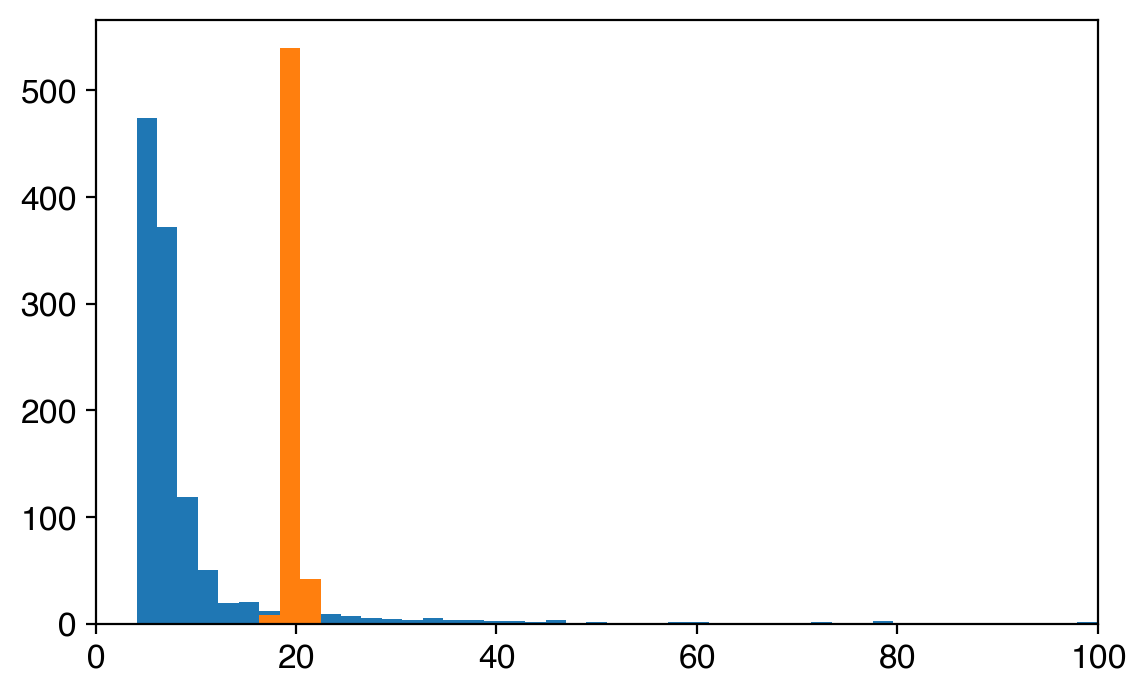

In [80]:
df_data.tree.draw("dimuon_mass","dimuon_mass>5",bins=np.linspace(0,100,50)).plot()
df_mc.tree.draw("dimuon_mass","0.01*(dimuon_mass>5)",bins=np.linspace(0,100,50)).plot()
# df_data.query("dimuon_mass>5").eval("dimuon_pt")

In [81]:
# Hist2D(df_data.filter(like="dimuon_drjet").values)
# df_data[["dimuon_drjetold","dimuon_drjet","nJet"]]

## Plot dump

In [82]:
nevents = uproot.numentries("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v7//output_1.root","Events")
print(nevents)
xsec = 1e3 # fb
lumi = 1.0 # ifb
sigweight = lumi * xsec / nevents
sigweight

497000


0.002012072434607646

plots_scouting_massgt5_iso/splitnone_drmumu.png
plots_scouting_massgt5_iso/splitnone_detamumu.png
plots_scouting_massgt5_iso/spliteta_drmumu.png
plots_scouting_massgt5_iso/spliteta_detamumu.png
plots_scouting_massgt5_iso/splitrho_drmumu.png
plots_scouting_massgt5_iso/splitrho_detamumu.png
plots_scouting_massgt5_iso/splitmass_drmumu.png
plots_scouting_massgt5_iso/splitmass_detamumu.png


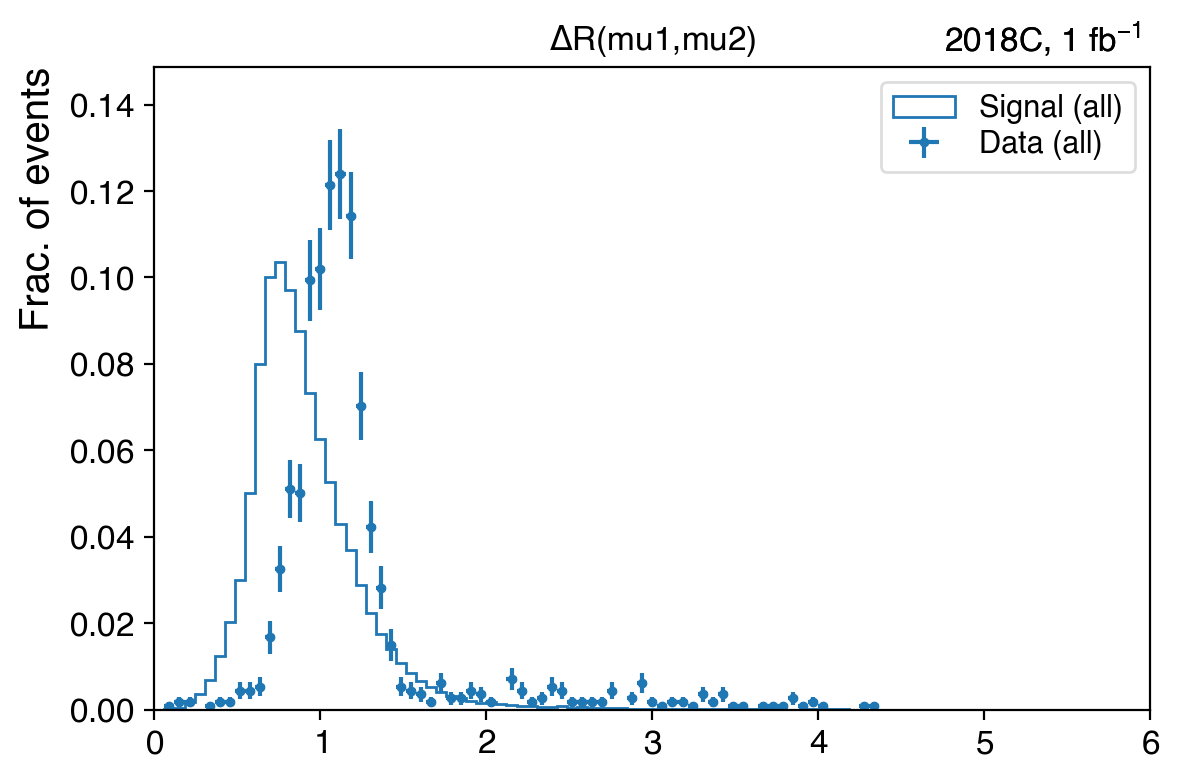

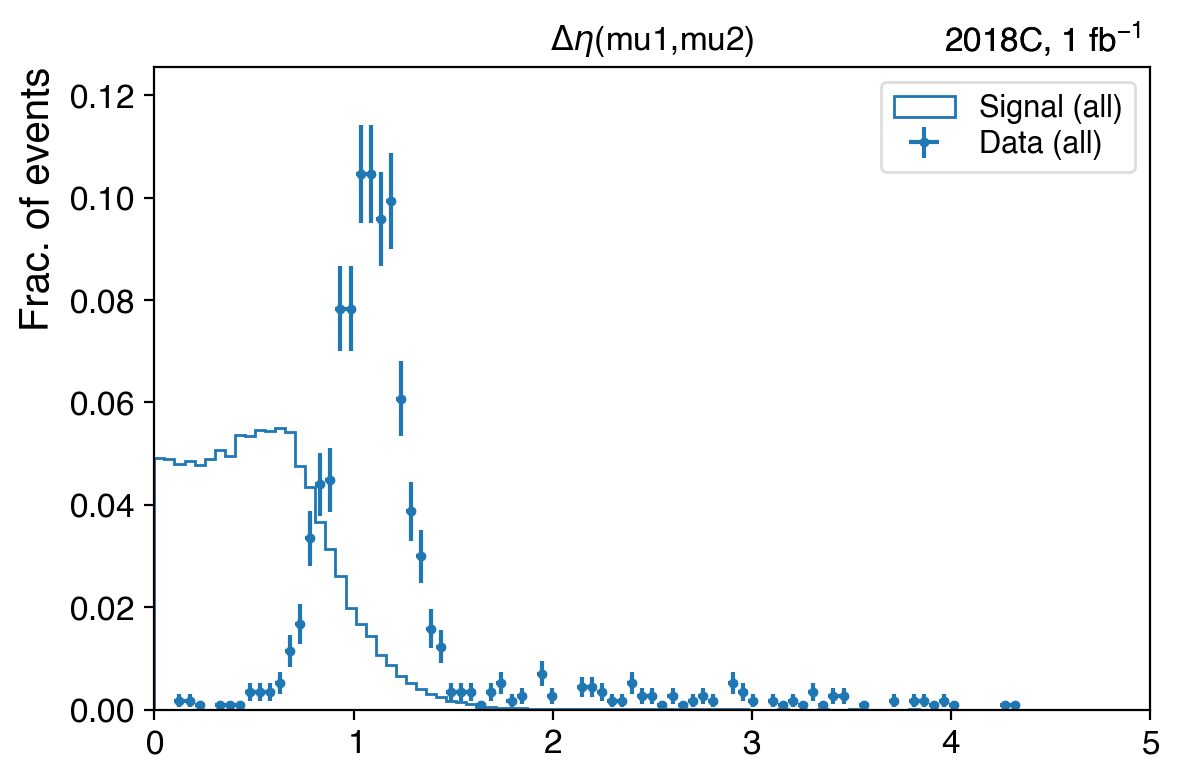

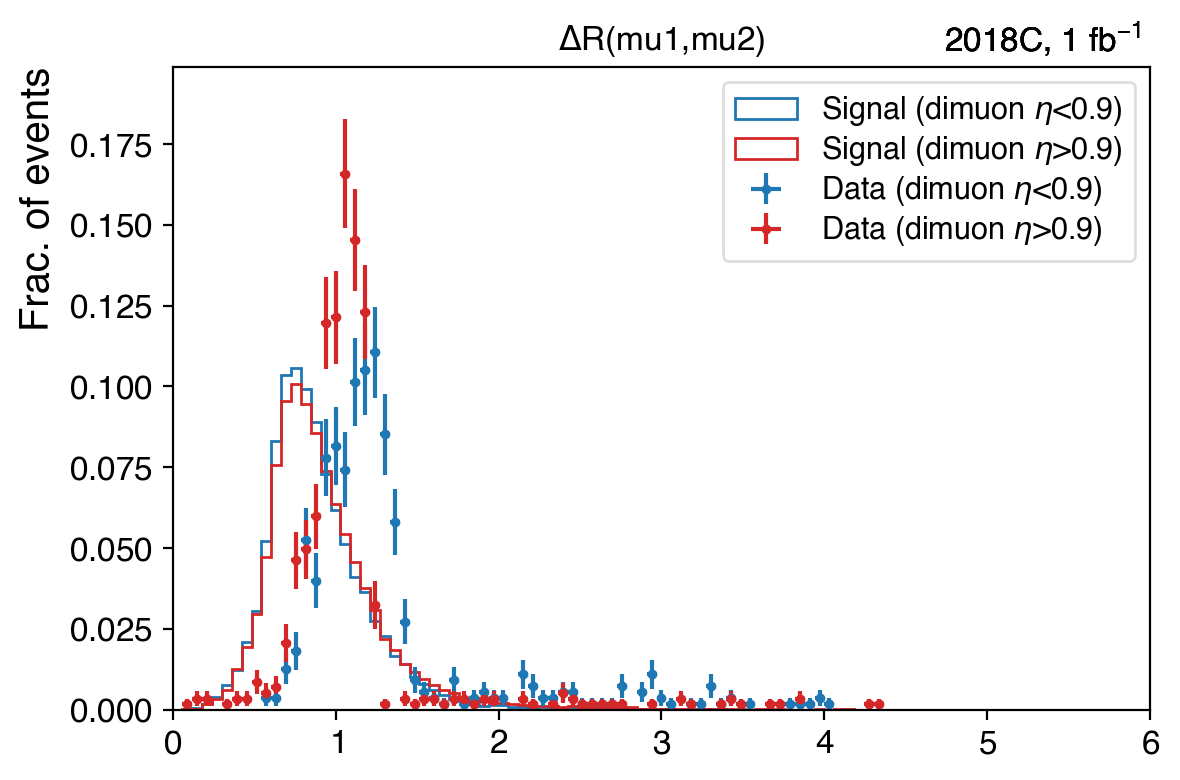

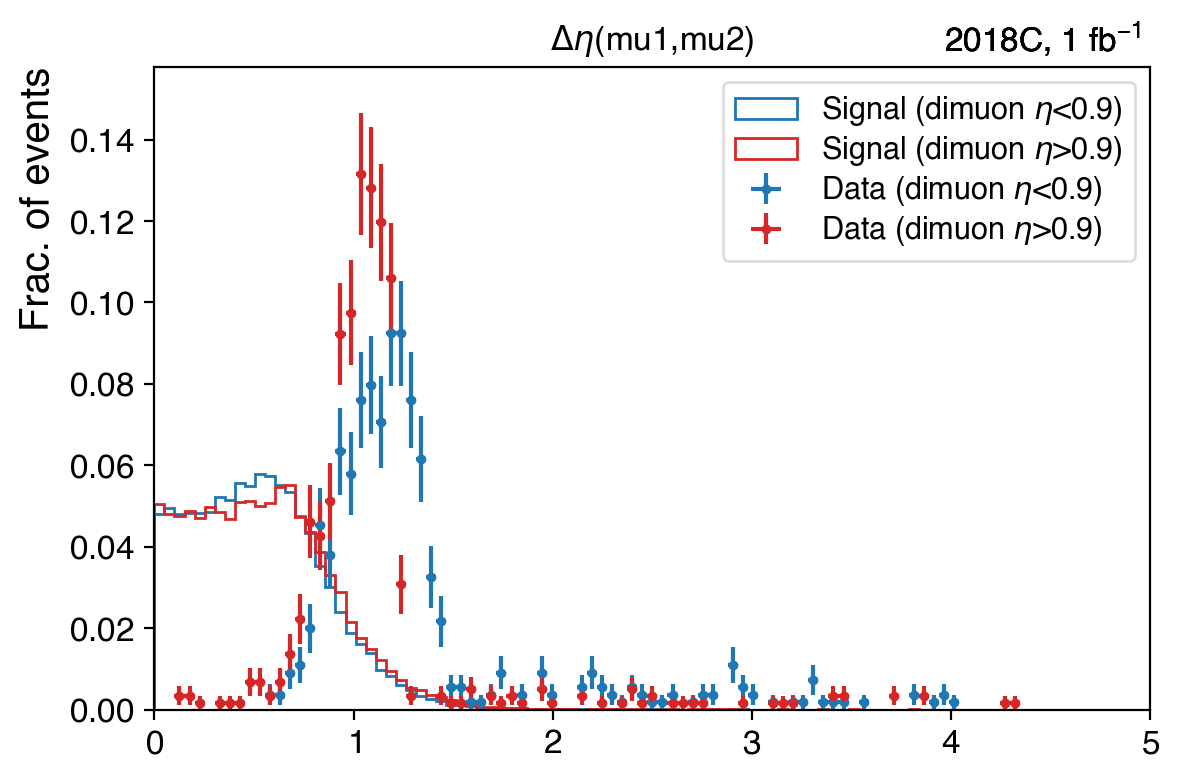

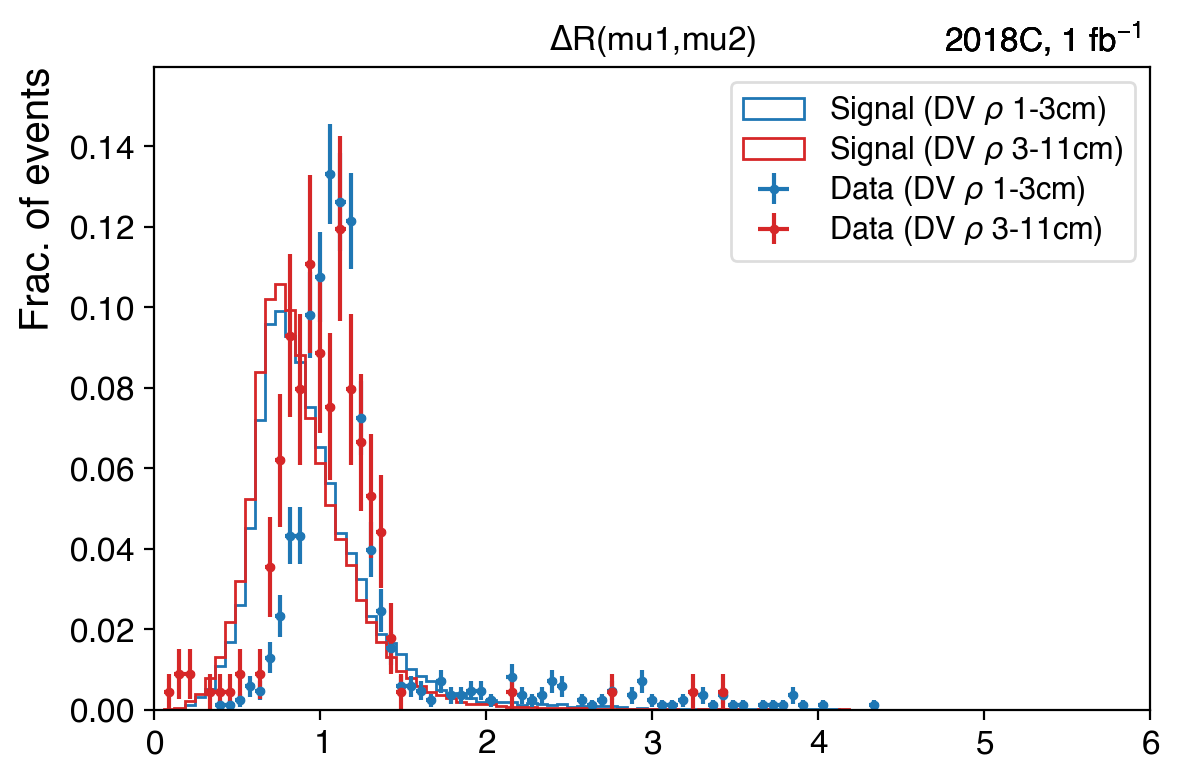

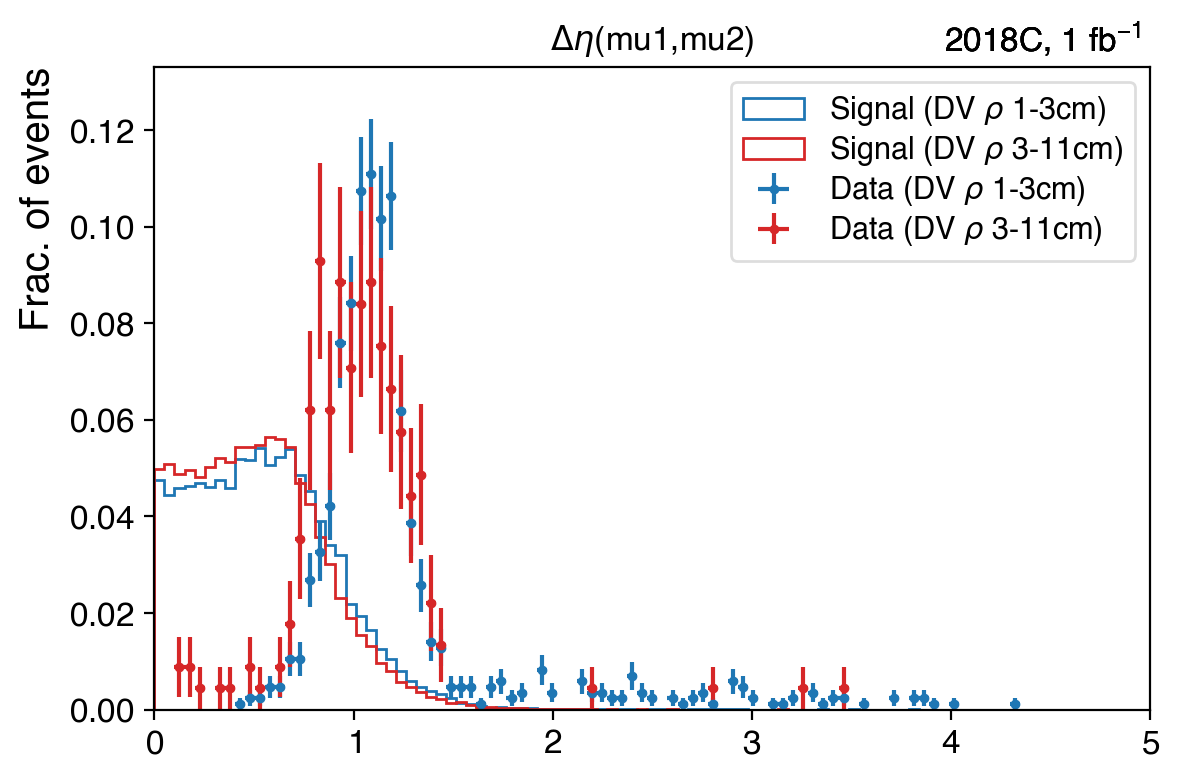

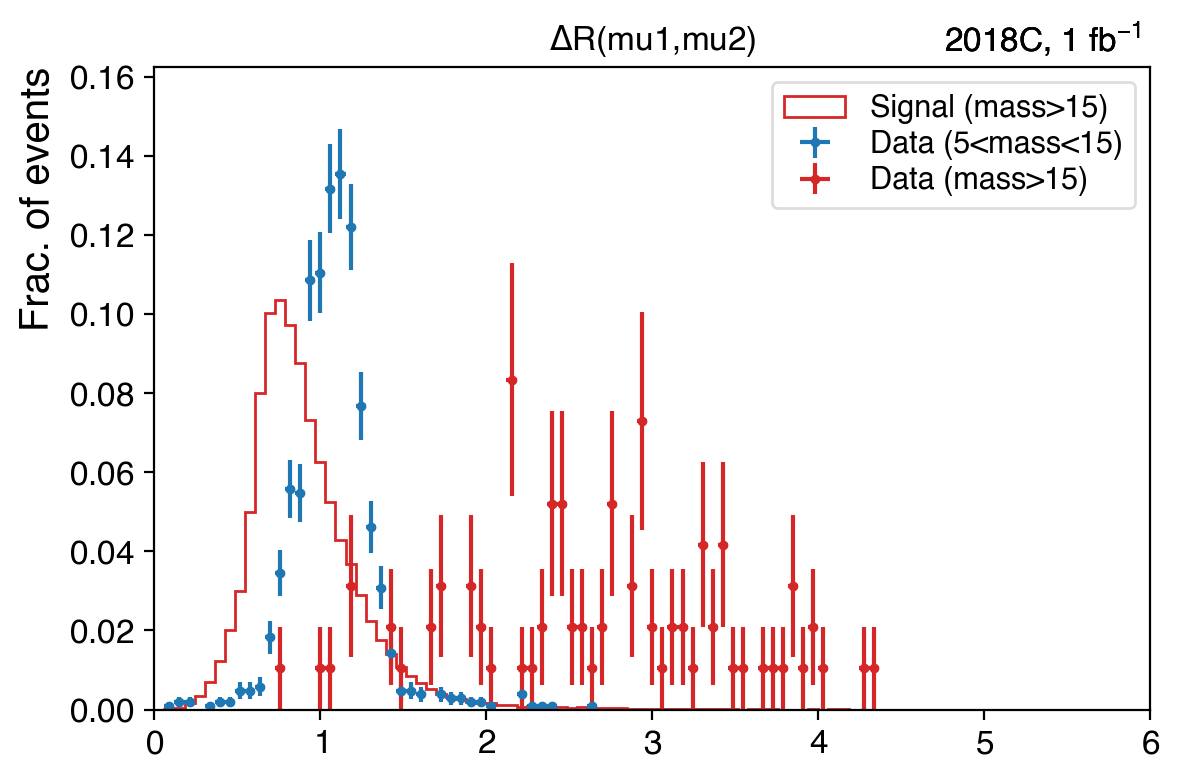

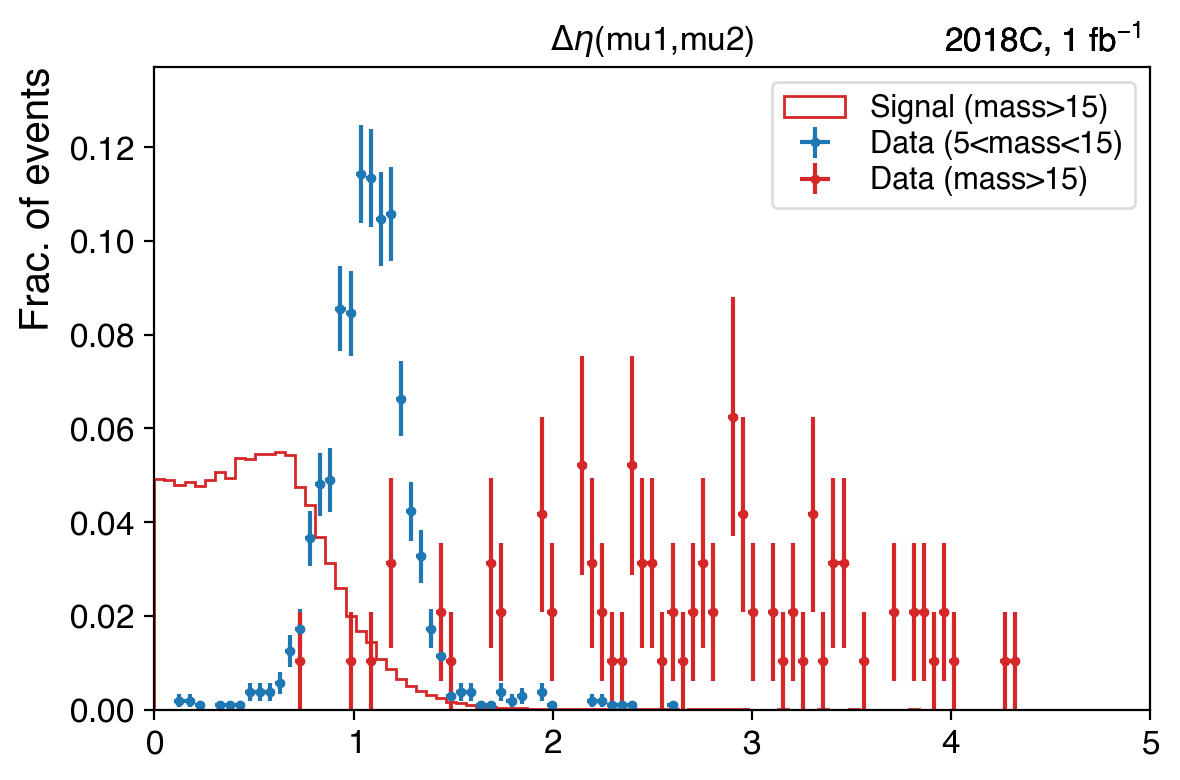

In [84]:
# plotdir = "plots_split_v4/"
plotdir = "plots_scouting_massgt5_iso"
os.system("mkdir -p {}".format(plotdir))

globalsel = "dimuon_mass>5"
normalize = True

selinfos = []

selinfos.append(dict(vsels=[
    ["all",lambda df: slice(None)],
],split_label = "splitnone"))

selinfos.append(dict(vsels=[
    [r"dimuon $\eta$<0.9",lambda df:  np.abs(df["dimuon_eta"])<0.9],
    [r"dimuon $\eta$>0.9",lambda df: np.abs(df["dimuon_eta"])>0.9],
],split_label = "spliteta"))

selinfos.append(dict(vsels=[
    [r"DV $\rho$ 1-3cm",lambda df:  (np.abs(df["DV_rhoCorr"])<3.0) & (np.abs(df["DV_rhoCorr"])>1.0)],
    [r"DV $\rho$ 3-11cm",lambda df:  (np.abs(df["DV_rhoCorr"])<11.0) & (np.abs(df["DV_rhoCorr"])>3.0)],
],split_label = "splitrho"))

selinfos.append(dict(vsels=[
    ["5<mass<15",lambda df:  (df["dimuon_mass"]<15) & (df["dimuon_mass"]>5)],
    ["mass>15",lambda df:  (df["dimuon_mass"]>15)],
],split_label = "splitmass"))

plotinfos = [
    
    [[lambda df: df["Muon1_nValidPixelHits"],lambda df: df["Muon2_nValidPixelHits"]], np.arange(10)-0.5, dict(title="Muon nValidPixelHits",shortname="nValidPixelHits")],
    [[lambda df: df["Muon1_nValidStripHits"],lambda df: df["Muon2_nValidStripHits"]], np.arange(30)-0.5, dict(title="Muon nValidStripHits",shortname="nValidStripHits")],
    
    
    [[lambda df: df["Muon1_nExpectedPixelHits"],lambda df: df["Muon2_nExpectedPixelHits"]], np.arange(12)-0.5, dict(title="Muon nExpectedPixelHits",shortname="nExpectedPixelHits")],
    [[lambda df: df.eval("Muon1_nValidPixelHits-Muon1_nExpectedPixelHits"),lambda df: df.eval("Muon2_nValidPixelHits-Muon2_nExpectedPixelHits")], np.arange(10)-5.5, dict(title="Muon n(Valid-Expected)PixelHits",shortname="nValidMinusExpectedPixelHits")],
    
    [[lambda df: df["Muon1_nTrackerLayersWithMeasurement"],lambda df: df["Muon2_nTrackerLayersWithMeasurement"]], np.arange(20)-0.5, dict(title="Muon nTrackerLayersWithMeasurement",shortname="nTrackerLayers")],
    [[lambda df: df["Muon1_nMatchedStations"],lambda df: df["Muon2_nMatchedStations"]], np.arange(7)-0.5, dict(title="Muon nMatchedStations",shortname="nMatchedStations")],
    [[lambda df: df["Muon1_nValidMuonHits"],lambda df: df["Muon2_nValidMuonHits"]], np.arange(60)-0.5, dict(title="Muon nValidMuonHits",shortname="nValidMuonHits")],
    
    [[lambda df: df["Muon1_eta"],lambda df: df["Muon2_eta"]], np.linspace(-2.5,2.5,50), dict(title="Muon eta",shortname="eta")],
    [[lambda df: df["Muon1_phi"],lambda df: df["Muon2_phi"]], np.linspace(-3.2,3.2,50), dict(title="Muon phi",shortname="phi")],
    [[lambda df: df["Muon1_pt"],lambda df: df["Muon2_pt"]], np.linspace(0,100,50), dict(title="Muon pT",shortname="pt")],
    [[lambda df: np.abs(df["Muon1_dxyCorr"]),lambda df: np.abs(df["Muon2_dxyCorr"])], np.linspace(0.0,6,150), dict(title="abs(Muon dxy)",logy=True,logx=True,shortname="absdxy")],
    [[lambda df: df["Muon1_dxyCorr"],lambda df: df["Muon2_dxyCorr"]], np.linspace(-5,5,150), dict(title="(signed) Muon dxy",logy=True,shortname="signeddxy")],
    [[lambda df: df["maxdxy"]], np.linspace(-6,6,150), dict(title="max(Muon1 dxy, Muon2 dxy)",logy=True,shortname="maxdxy")],
    [[lambda df: df["mindxy"]], np.linspace(-6,6,150), dict(title="min(Muon1 dxy, Muon2 dxy)",logy=True,shortname="mindxy")],
    [[lambda df: df["maxabsdxy"]], np.linspace(-6,6,150), dict(title="max(abs(Muon1 dxy), abs(Muon2 dxy))",logy=True,shortname="maxabsdxy")],
    [[lambda df: df["minabsdxy"]], np.linspace(-6,6,150), dict(title="min(abs(Muon1 dxy), abs(Muon2 dxy))",logy=True,shortname="minabsdxy")],
    [[lambda df: df["Muon1_dxyError"],lambda df: df["Muon2_dxyError"]], np.linspace(0.001,0.02,150), dict(title="Muon dxy Error",logy=True,shortname="dxyError")],
    
    [[lambda df: df["Muon1_redchi2"],lambda df: df["Muon2_redchi2"]], np.linspace(0,5,100), dict(title="Muon chi2/ndof",shortname="Muonchi2")],
    [[lambda df: df["Muon1_adqpt"],lambda df: df["Muon2_adqpt"]], np.linspace(0,0.05,100), dict(title="Muon abs(qoverpError/qoverp)",shortname="relqoverp")],
    [[lambda df: df["Muon1_trackIso"],lambda df: df["Muon2_trackIso"]], np.linspace(0,0.1,50), dict(title="Muon trackIso",logy=True,shortname="trackIso")],
    [[lambda df: df["Muon1_drjet"],lambda df: df["Muon2_drjet"]], np.linspace(0,2*np.pi,100), dict(title="dR(muon,closest jet)",shortname="drjet")],
    
    [[lambda df: df["DV_inPixelRectangles"]], np.linspace(-0.5,1.5,3), dict(title="Is in pixel rectangle?",shortname="inPixel")],
    [[lambda df: df["DV_rhoCorr"]], np.linspace(0.1,12,100), dict(title="DV rho (logscale)",logy=True,shortname="rholog")],
    [[lambda df: df["DV_rhoCorr"]], np.linspace(0.1,12,100), dict(title="DV rho",logy=False,shortname="rho")],
    [[lambda df: df["absdphimumu"]], np.linspace(0,2.0,150), dict(title="abs(dphi(mu1,mu2))",shortname="dphimumu")],
    [[lambda df: df["absdphimumu"]], np.linspace(0,2.0,150), dict(title="abs(dphi(mu1,mu2)), logscale",logx=True,logy=True,shortname="dphimumulog")],
    [[lambda df: df["absdphimudv"]], np.linspace(0,0.03,50), dict(title="abs(dphi(dimuon,DV))",shortname="dphimudv")],
    [[lambda df: df["dimuon_mass"]], np.linspace(5,40,80), dict(title="Dimuon mass",logy=False,logx=False,shortname="mass")],
    [[lambda df: df["dimuon_mass"]], np.linspace(5,40,36), dict(title="Dimuon mass (logscale)",logy=True,logx=False,shortname="masslog")],
    [[lambda df: df["dimuon_pt"]], np.linspace(0,100,200), dict(title="Dimuon pT",shortname="dimuonpt")],
    [[lambda df: df["dimuon_drjet"]], np.linspace(0,2*np.pi,100), dict(title="dR(dimuon,closest jet)",shortname="dimudrjet")],
    
    [[lambda df: df["DV_zError"]], np.linspace(0.0,0.1,50), dict(title="DV zError",shortname="zError")],
    [[lambda df: df["DV_xyErrorMax"]], np.linspace(0.0,0.05,50), dict(title="DV max(xError,yError)",shortname="xyErrorMax")],
    [[lambda df: df["DV_redchi2"]], np.linspace(0.0,10.0,100), dict(title="DV chi2/ndof",shortname="DVchi2")],
    [[lambda df: np.log10(df["DV_redchi2"])], np.linspace(-5,1.5,100), dict(title="DV log10(chi2/ndof)",shortname="DVlogchi2")],
    
    [[lambda df: df["nPV"]], np.arange(40)-0.5, dict(title="nPV (from hltPixelVertices)",shortname="nPV")],
    [[lambda df: df["nPVM"]], np.arange(15)-0.5, dict(title="nPVM (from hltPixelVerticesL3MuonNoVtx)",shortname="nPVM")],
    [[lambda df: df["nJet"]], np.arange(15)-0.5, dict(title="nJet",shortname="njets")],
    
    [[lambda df: df["angle3dmumu"]], np.linspace(0,3.142,50), dict(title="3d angle between mu1 and mu2",shortname="angle3dmumu")],
    [[lambda df: df["angle3dmudv"]], np.linspace(0,3.142,50), dict(title="3d angle between dimuon and DV",shortname="angle3dmudv")],
    
    [[lambda df: df["dimuon_deltar"]], np.linspace(0,6,100), dict(title="$\Delta$R(mu1,mu2)",shortname="drmumu")],
    [[lambda df: df["dimuon_deltaeta"]], np.linspace(0,5,100), dict(title="$\Delta\eta$(mu1,mu2)",shortname="detamumu")],
    
]

# plotinfos = [
#     [[lambda df: df["dimuon_deltar"]], np.linspace(0,6,100), dict(title="$\Delta$R(mu1,mu2)",shortname="drmumu")],
#     [[lambda df: df["dimuon_deltaeta"]], np.linspace(0,5,100), dict(title="$\Delta\eta$(mu1,mu2)",shortname="detamumu")],
# ]

# #     [],
    

for selinfo in selinfos:
    vsels = selinfo["vsels"]
    split_label = selinfo["split_label"]
    
    for fs,bins,opts in plotinfos:
        fig,ax = plt.subplots()

        ymax = 0.
        datanorms = {}
        for df,label,linestyle in [
            [df_data,"Data","-"],
            [df_mc,"Signal","-"],
        ]:
            

            for (sel_label,fsel),color in zip(vsels,["C0","C3","C2","C1"]):
                
                # skip low stats MC splits
                if (label == "Signal") and (("mass<5" in sel_label) or ("mass<15" in sel_label)): continue
                    
                if globalsel:
                    df = df.query(globalsel)
                sel = fsel(df)
                h = sum([Hist1D(f(df)[sel],bins=bins) for f in fs])
                if normalize:
                    h = h.normalize()
                else:
                    if "signal" in label.lower():
                        h *= (datanorms[sel_label]/h.counts.sum())
                        label = r"Signal (norm. to data)"
#                         h *= sigweight
#                         label = r"Signal ($\sigma$={:g}pb)".format(xsec/1000)
                if label == "Data":
                    datanorms[sel_label] = h.counts.sum()
#                     h.plot(ax=ax,label="{} ({})".format(label,sel_label),color="k",show_errors=True,markersize=2.5);
                    h.plot(ax=ax,label="{} ({})".format(label,sel_label),color=color,show_errors=True,markersize=2.5);
                else:
                    h.plot(ax=ax,label="{} ({})".format(label,sel_label),color=color,histtype="step",linestyle=linestyle);
                ax.text(0.99, 1.01,"2018C, 1 fb${}^\mathregular{-1}$", horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes, size="large")
                ymax = max(ymax,h.counts.max())

        if opts.get("logx"):
            ax.set_xscale("log")

        if opts.get("logy"):
            ax.set_ylim(0.00001,ymax*1.5)
            ax.set_yscale("log")
        else:
            ax.set_ylim(ax.get_ylim()[0],ymax*1.2)

        ax.set_xlabel(opts.get("xlabel",""),horizontalalignment="right",x=1.)
        ylabel = "Frac. of events" if normalize else "Events"
        ax.set_ylabel(opts.get("ylabel",ylabel),horizontalalignment="right",y=1.)
        ax.set_title(opts.get("title",""))
        
        ax.legend()
        
        shortname = opts.get("shortname","unknown")
        fname = "{}/{}_{}.png".format(plotdir,split_label,shortname)
        print(fname)
#     break
        fig.set_tight_layout(True)
        fig.savefig(fname,dpi=150)
        
        # Don't show the figure in the notebook
        plt.close()
#         break

In [74]:

with open("{}/description.txt".format(plotdir),"w") as fh:
    fh.write("""
Selection: 
<ul>
<li>==2 OS muons, ==1 DV</li>
<li>1cm < DV rho < 11cm</li>
<li>cos(dphi(dimuon,DV))>0</li>
<li>max(DV_xError,yError)<0.05cm, DV_zError<0.1cm</li>
<li>valid muon hits>0 for each muon</li>
<li>|dphi(mu1,mu2)|<2.8</li>
<li>|dphi(dimuon,DV)| < 0.02</li>
<li>Muon trackIso < 0.1 for each muon</li>
<li>dR(muon,closest jet) > 0.3 for each muon</li>
<li>Muon chi2/ndof < 3</li>
</ul>
Split plots by:
<ul>
<li>nothing ("splitnone_")</li>
<li>DV rho ("splitrho_")</li>
<li>eta of dimuon system ("spliteta_")</li>
<li>mass of dimuon system ("splitmass_")</li>
</ul>
    """)

!niceplots {plotdir}

Not converting anything
ln: creating symbolic link `plots_scouting_massgt5_iso/index.php': File exists
uaf-10.t2.ucsd.edu/~namin/dump/plots/plots_scouting_massgt5_iso/


In [61]:
df_mc[["Muon1_vtxIdx1","Muon2_vtxIdx1"]]

,Muon1_vtxIdx1,Muon2_vtxIdx1
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
59395,0,0
59396,0,0
59397,0,0
59398,0,0


In [63]:
#  from cosmicscheck notebook
import json
df = pd.DataFrame(
    json.loads(
        '{"fname":{"961":"\\/hadoop\\/cms\\/store\\/group\\/snt\\/run2_data2018\\/MET_Run2018C-17Sep2018-v1_MINIAOD_CMS4_V10-02-04\\/merged_ntuple_104.root","1145":"\\/hadoop\\/cms\\/store\\/group\\/snt\\/run2_data2018\\/SingleMuon_Run2018C-17Sep2018-v1_MINIAOD_CMS4_V10-02-04\\/merged_ntuple_113.root"},"rle":{"961":[[319678,209,292576462]],"1145":[[319639,207,296757079],[319658,155,249146307]]}}'
    )
)
df
# pd.read_json()

,fname,rle
961,/hadoop/cms/store/group/snt/run2_data2018/MET_...,"[[319678, 209, 292576462]]"
1145,/hadoop/cms/store/group/snt/run2_data2018/Sing...,"[[319639, 207, 296757079], [319658, 155, 24914..."


In [66]:
df.fname.values

array(['/hadoop/cms/store/group/snt/run2_data2018/MET_Run2018C-17Sep2018-v1_MINIAOD_CMS4_V10-02-04/merged_ntuple_104.root',
       '/hadoop/cms/store/group/snt/run2_data2018/SingleMuon_Run2018C-17Sep2018-v1_MINIAOD_CMS4_V10-02-04/merged_ntuple_113.root'],
      dtype=object)

In [75]:
df_data.query("dimuon_mass>15")[["Muon1_eta","Muon"]]

,nDV,nDV_good,nJet,nPV,nPVM,nMuon,nMuon_good,nGenPart,nGenMuon,pass_skim,...,DV_redchi2,DV_xyErrorMax,Muon1_redchi2,Muon2_redchi2,Muon1_adqpt,Muon2_adqpt,maxabsdxy,minabsdxy,maxdxy,mindxy
35,1,1,1,12,2,2,2,0,0,True,...,10.100648,0.001387,0.672301,0.775829,0.019685,0.015638,0.013508,0.000132,0.013508,0.000132
946,1,1,0,11,2,2,2,0,0,True,...,0.000058,0.004735,0.859811,0.565181,0.007536,0.020528,0.005797,0.000003,0.005797,0.000003
2223,1,1,0,17,2,2,2,0,0,True,...,0.167922,0.002261,0.888956,0.745557,0.022920,0.014743,0.021405,0.004300,0.004300,-0.021405
3311,1,1,0,22,7,2,2,0,0,True,...,0.425282,0.002220,0.816524,0.797950,0.008957,0.017705,0.005565,0.000287,0.005565,-0.000287
3409,1,1,0,18,7,2,2,0,0,True,...,1.297735,0.001775,0.916737,1.091363,0.015494,0.020021,0.016098,0.010770,0.016098,-0.010770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41218,1,1,1,21,5,2,2,0,0,True,...,4.202562,0.002541,0.904274,1.114438,0.010049,0.009320,0.015384,0.000786,0.015384,0.000786
41349,1,1,0,16,3,2,2,0,0,True,...,0.002298,0.001734,1.197214,0.761150,0.020086,0.013663,0.003517,0.000915,-0.000915,-0.003517
41948,1,1,0,18,5,2,2,0,0,True,...,7.539555,0.002287,0.890589,0.600525,0.016576,0.019087,0.008049,0.004722,0.008049,-0.004722
42142,1,1,0,20,6,2,2,0,0,True,...,3.512847,0.002021,0.903695,2.664358,0.017539,0.026740,0.002159,0.001520,0.002159,-0.001520


/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_laun

/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arccos


<generator object Executor.map.<locals>.result_iterator at 0x7f252567e2a0>


In [25]:

# fnames_mc = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v7//output_1.root")
# futures_mc = executor.map(make_df, fnames_mc)
# fnames_data = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_v7skim1cmjets/*.root")
# futures_data = executor.map(make_df, fnames_data)
# df_data = pd.concat(tqdm(futures_data,total=len(fnames_data))).reset_index(drop=True)
# df_mc = pd.concat(tqdm(futures_mc,total=len(fnames_mc))).reset_index(drop=True)

fnames_data = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_v7jets/*.root")
fnames_data[0]
# for arrs in uproot.iterate(fnames_data[0],"Events",branches=["n*","pass_*",
#                      "MET_*",
#                      "/BS_(x|y|z)$/",
#                      "/Jet_(pt|eta|phi|m)$/",
#                      "/Muon_(pt|eta|phi|m|n.*|trackIso|charge|trk_qoverp.*|dxy.*|chi2|ndof|vx|vy|vz|vtxIdx.*|jetIdx.*|good|drjet)$/",
#                      "/DV_(tracksSize|chi2|ndof|rho.*|inPixel.*|x|y|z|xError|yError|zError|good)$/",
#                      "run","luminosityBlock","event",
#                      "L1_DoubleMu4p5_SQ_OS_dR_Max1p2",
#                      "L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4",
#                      "L1_DoubleMu_15_7",
#                     ],entrysteps=int(50e3)):
#     print(arrs)
#     break
make_df(fnames_data[0],0,1000,bigrho=False)

,nDV,nDV_good,nJet,nPV,nPVM,nMuon,nMuon_good,nGenPart,nGenMuon,pass_skim,...,DV_redchi2,DV_xyErrorMax,Muon1_redchi2,Muon2_redchi2,Muon1_adqpt,Muon2_adqpt,maxabsdxy,minabsdxy,maxdxy,mindxy
20,1,1,2,0,8,2,2,0,0,True,...,0.020530,0.005662,0.881996,0.709323,0.014361,0.018050,0.118653,0.115305,0.115305,-0.118653
88,1,1,1,0,5,2,2,0,0,True,...,2.698214,0.035886,0.056817,1.514017,0.046614,0.038092,0.032491,0.031100,0.032491,-0.031100
129,1,1,1,0,13,2,2,0,0,True,...,0.226541,0.017758,0.945496,0.775739,0.020329,0.025260,0.101605,0.055473,0.055473,-0.101605
146,1,1,0,0,4,2,2,0,0,True,...,0.033814,0.023076,0.412180,0.097294,0.045738,0.039880,0.055235,0.050056,0.050056,-0.055235
237,1,1,0,0,11,2,2,0,0,True,...,1.819901,0.012300,1.208733,0.548387,0.106166,0.060724,0.017988,0.002759,0.017988,-0.002759
306,1,1,1,0,5,2,2,0,0,True,...,0.572781,0.021155,0.601870,0.447349,0.269673,0.188948,0.098142,0.067224,0.067224,-0.098142
456,1,1,0,0,3,2,2,0,0,True,...,0.845934,0.007262,2.002372,1.018990,0.008454,0.007317,0.027991,0.023262,0.027991,-0.023262
469,1,1,2,0,10,2,2,0,0,True,...,0.000095,0.011023,1.545653,0.591931,0.014237,0.013825,0.024962,0.004691,0.004691,-0.024962
478,1,1,3,26,8,2,2,0,0,True,...,0.766261,0.017862,0.709741,2.026400,0.009039,0.009392,0.028822,0.013237,0.013237,-0.028822
480,1,1,2,25,8,2,2,0,0,True,...,1.791249,0.013791,0.907095,0.722137,0.017088,0.014812,0.079661,0.062893,0.079661,-0.062893


In [28]:
from dask.distributed import Client
import dask.dataframe as dd
from dask import delayed
import utils

In [43]:
client = Client("uaf-10.t2.ucsd.edu:50123")
client

Client Scheduler: tcp://uaf-10.t2.ucsd.edu:50123 Dashboard: http://uaf-10.t2.ucsd.edu:8787/status,Cluster Workers: 9 Cores: 9 Memory: 45.00 GB


In [48]:
delayed_make_df = delayed(make_df)

In [45]:
chunks, total_events = utils.get_chunking_dask(tuple(fnames_data),500e3,client=client)
len(chunks)

In [60]:
meta = make_df(chunks[0][0],0,1000,bigrho=False)
df = dd.from_delayed((delayed_make_df(*chunk,bigrho=False) for chunk in chunks),meta=meta).persist()

In [61]:
print(len(df))
print((df.memory_usage().sum()/1e6).compute())
localdf = df.compute()
localdf.to_pickle("data/df_data_allrho.pkl")

1291305

In [75]:
chunks, total_events = utils.get_chunking_dask(tuple(fnames_mc),500e3,client=client)
print(len(chunks))
(dd.from_delayed((delayed_make_df(*chunk,bigrho=False) for chunk in chunks),meta=meta)
 .compute()
 .to_pickle("data/df_mc_allrho.pkl")
)

1
